## CPU Isochrones

### Load Libraries

In [1]:
from descartes import PolygonPatch
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from shapely.geometry import Point, LineString, Polygon
from IPython.display import IFrame


ox.config(log_console=True, use_cache=True)

## Create Network Graphs

In [2]:
def create_graph(loc, dist, transport_mode, loc_type="address"):
    # Transport mode = ‘walk’, ‘bike’, ‘drive’, ‘drive_service’, ‘all’, ‘all_private’, ‘none’
    if loc_type == "address":
        G = ox.graph_from_address(loc, dist=dist, network_type=transport_mode)
    elif loc_type == "points":
        G = ox.graph_from_point(loc, dist=dist, network_type=transport_mode )
    return G

In [3]:
%%time

# Place you are interested
place = '900 North High Street, Columbus, OH 43125'

# Transportation mode
mode = 'drive'  # options are 'walk', 'drive'

# Create network graph from place and mode
G = create_graph(place, dist=40000, transport_mode=mode, loc_type='address')

CPU times: user 3min 21s, sys: 1.93 s, total: 3min 23s
Wall time: 3min 24s


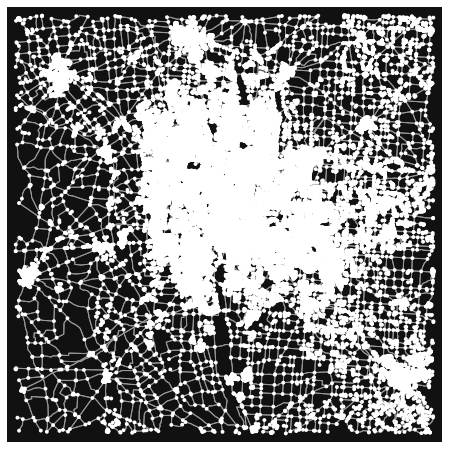

<Figure size 432x288 with 0 Axes>

CPU times: user 46 s, sys: 2.72 s, total: 48.7 s
Wall time: 44.1 s


In [4]:
%%time

fig, ax = ox.plot_graph(G, save=True);
plt.tight_layout()
#plt.savefig("graph.png")
plt.show()

In [5]:
# %%time

# graph_map = ox.plot_graph_folium(coordinates, popup_attribute='name', edge_width=2)
# # save as html file then display map as an iframe
# filepath = 'coordinates.html'
# graph_map.save(filepath)
# IFrame(filepath, width=900, height=500)

## Create Isochrones from Network Graphs

In [6]:
%%time

# Create nodes geodataframe from Graph network (G)
gdf_nodes = ox.graph_to_gdfs(G, edges=False)

CPU times: user 3.09 s, sys: 3.99 ms, total: 3.09 s
Wall time: 3.09 s


In [7]:
%%time

# Specify where you want to start and get nearest nodes. 
point_of_interest = ox.get_nearest_node(G, point=(39.98042534774855, -82.9957527350642))

CPU times: user 93.7 ms, sys: 50 µs, total: 93.7 ms
Wall time: 92 ms


In [8]:
%%time

# Project a graph from lat-long to the UTM zone appropriate for its geographic location.
G = ox.project_graph(G)

CPU times: user 38.9 s, sys: 32.1 ms, total: 38.9 s
Wall time: 38.9 s


In [9]:
%%time

# Trip time in Mintues
trip_times = [5, 10, 15, 30, 60]

# average driving speed in km/hour
travel_speed = 35
meters_per_minute = travel_speed * 1000 / 60 # km per hour to m per minute

# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

CPU times: user 249 ms, sys: 3.93 ms, total: 253 ms
Wall time: 251 ms


In [10]:
%%time

# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True)

# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, point_of_interest, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color

CPU times: user 7.77 s, sys: 85 µs, total: 7.77 s
Wall time: 7.76 s


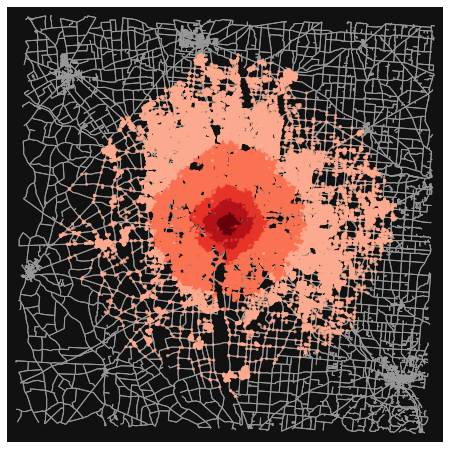

CPU times: user 30.9 s, sys: 140 ms, total: 31.1 s
Wall time: 30.8 s


In [11]:
%%time

nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [10 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, figsize=(8, 8), node_color=nc, node_size=ns, save=True, node_alpha=0.8, node_zorder=2)

In [12]:
%%time

# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, point_of_interest, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)

CPU times: user 12.6 s, sys: 11.9 ms, total: 12.6 s
Wall time: 12.6 s


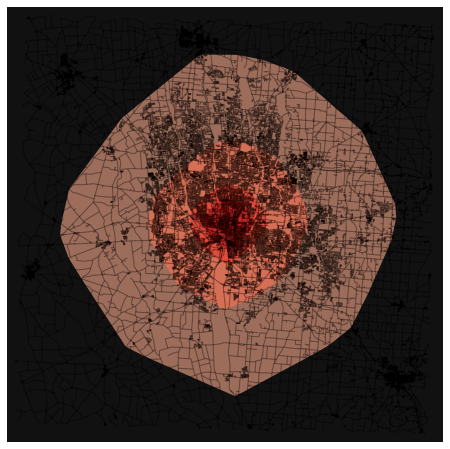

CPU times: user 29.2 s, sys: 160 ms, total: 29.4 s
Wall time: 29.1 s


In [13]:
%%time

# plot the network then add isochrones as colored descartes polygon patches
fig, ax = ox.plot_graph(G, figsize=(8, 8), show=False, close=False, save=True, edge_color='k', edge_alpha=0.2, node_color='none')
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()